In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gaia_download import vari_class, vari_short_timescale
import gPhoton
from download_isochrone import load_isochrone
from extinction import add_colors_and_abs_mag
import plotly.graph_objects as go
from simbad_download import fetch_catalog_id
import pyvo as vo

from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from download_lightcurves import download_dr3_lightcurve

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Configuration file not found:

    /home/maya/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [2]:
CLUSTER_NAME: str = 'King 11'

In [16]:
bss_candidates = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_bss.csv')
yss_candidates = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_yss.csv')

bss_candidates = add_colors_and_abs_mag(bss_candidates)
yss_candidates = add_colors_and_abs_mag(yss_candidates)

In [17]:
sources = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
clustered = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
isochrone = load_isochrone(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_isochrone.dat')

In [18]:
bss_candidates = bss_candidates[bss_candidates.G_abs_error<=np.quantile(bss_candidates.G_abs_error, [.16])[0]]

In [19]:
TO_COLOR = np.min(isochrone[:, 0])

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


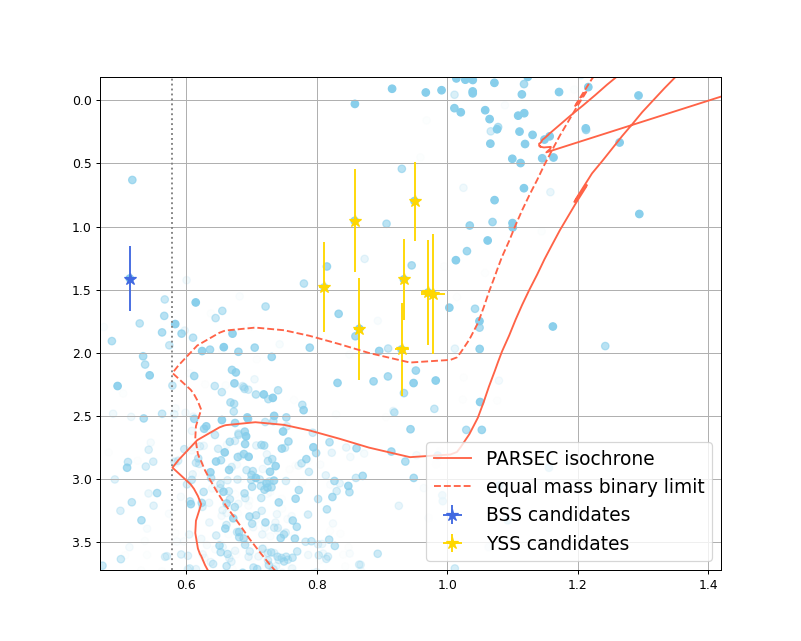

In [22]:
plt.figure(figsize=(10, 8))
TO_COLOR = np.min(isochrone[:, 0])
plt.scatter(clustered['BP-RP'], clustered['G_abs'], color='skyblue', alpha=clustered['occurences'])
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)

plt.plot(isochrone[:, 0], isochrone[:, 1], color='tomato', label='PARSEC isochrone')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, color='tomato', label='equal mass binary limit',
         linestyle='--')
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15, loc='lower right');
plt.grid();

<IPython.core.display.Javascript object>


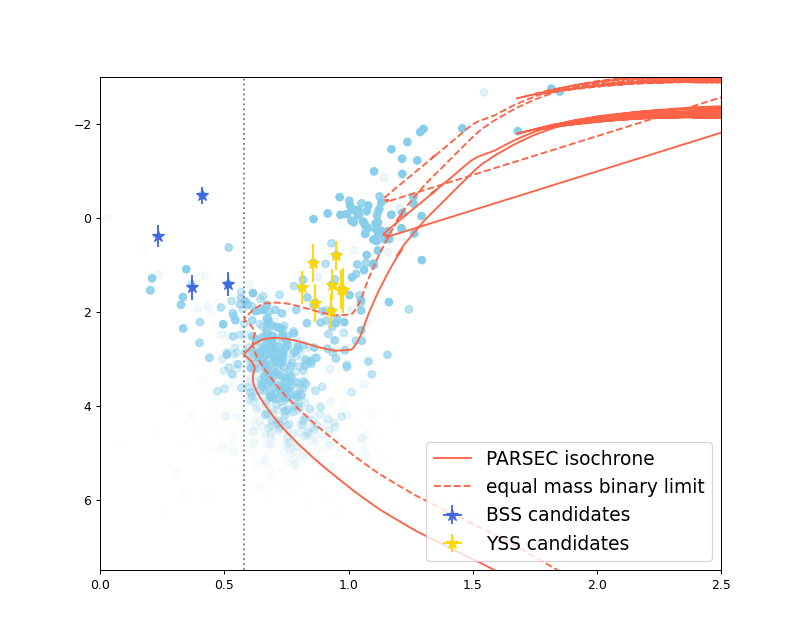

In [24]:
plt.figure(figsize=(10, 8))
TO_COLOR = np.min(isochrone[:, 0])
plt.scatter(clustered['BP-RP'], clustered['G_abs'], color='skyblue', alpha=clustered['occurences'])
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)

plt.plot(isochrone[:, 0], isochrone[:, 1], color='tomato', label='PARSEC isochrone')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, color='tomato', label='equal mass binary limit',
         linestyle='--')
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15, loc='lower right');
plt.gca().set_xlim(0, 2.5);
plt.gca().set_ylim(7.5, -3.);

# BSS variability

In [25]:
bss_candidates = add_colors_and_abs_mag(bss_candidates).drop_duplicates(subset=['source_id'])

In [26]:
bss_candidates.head()

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier
7,14,42514,1636148068921376768,Gaia DR3 2211126580772483968,2211126580772483968,965772321,2016.0,-3.102761,0.034413,68.664846,...,1.410283,0.909918,0.513604,0.003829,1.412117,0.258362,0.132060,0,0.95,-1
15,25,9628,1636148068921376768,Gaia DR3 2214223011673276288,2214223011673276288,1279339037,2016.0,-3.027693,0.017588,68.717451,...,1.352127,0.872396,0.411679,0.002167,-0.481753,0.180251,0.126902,0,0.80,-1
22,64,49017,1636148068921376768,Gaia DR3 2211198701861960960,2211198701861960960,1046332210,2016.0,-2.850923,0.023791,68.416310,...,1.468439,0.947441,0.231124,0.003667,0.388166,0.237649,0.136746,0,0.05,-1
23,67,49495,1636148068921376768,Gaia DR3 2211203065548697984,2211203065548697984,999647567,2016.0,-2.916993,0.031441,68.531781,...,1.352127,0.872396,0.369600,0.006524,1.477821,0.271240,0.129161,0,0.05,-1


In [27]:
bss_var = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

In [32]:
bss_candidates[bss_candidates.ruwe>1.4][['source_id', 'has_epoch_photometry', 'ruwe', 'excess', 'occurences']]

,source_id,has_epoch_photometry,ruwe,excess,occurences


In [33]:
np.any(bss_candidates.has_epoch_rv)

False

In [34]:
bss_rv_amplitude = bss_candidates.dropna(subset=['rv_amplitude_robust'])
bss_rv_amplitude[['source_id', 'radial_velocity', 'rv_amplitude_robust', 'radial_velocity_error']]

,source_id,radial_velocity,rv_amplitude_robust,radial_velocity_error


In [35]:
np.abs(bss_rv_amplitude.rv_amplitude_robust)>=6*bss_rv_amplitude.radial_velocity_error

Series([], dtype: bool)

In [36]:
bss_rv_amplitude.parallax_over_error

Series([], Name: parallax_over_error, dtype: float64)

In [37]:
bss_candidates.non_single_star

7     0
15    0
22    0
23    0
Name: non_single_star, dtype: int64

In [38]:
bss_rv_amplitude.G_abs

Series([], Name: G_abs, dtype: float64)

In [39]:
bss_rv_amplitude['BP-RP']

Series([], Name: BP-RP, dtype: float64)

In [40]:
for _, bss in bss_var.iterrows():
    print(f'{bss.source_id}: {bss.ra}, {bss.dec}:')
    gPhoton.gFind(skypos=[bss.ra, bss.dec])
    print()

# YSS variability

In [41]:
yss_var = yss_candidates[yss_candidates.phot_variable_flag=='VARIABLE'].drop_duplicates(subset=['source_id'])

In [42]:
yss_var

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier


In [43]:
yss_var.has_epoch_photometry

Series([], Name: has_epoch_photometry, dtype: bool)

In [44]:
for _, bss in yss_var.iterrows():
    print(f'{bss.source_id}: {bss.ra}, {bss.dec}:')
    gPhoton.gFind(skypos=[bss.ra, bss.dec])
    print()

In [45]:
yss_candidates.non_single_star

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: non_single_star, dtype: int64

In [46]:
yss_candidates.ruwe

0    0.927356
1    1.367425
2    1.007284
3    0.972425
4    0.954597
5    1.020474
6    1.056778
7    0.978792
Name: ruwe, dtype: float64

In [47]:
yss_rv_amplitude = yss_candidates.dropna(subset=['rv_amplitude_robust'])
yss_rv_amplitude[['source_id', 'rv_amplitude_robust', 'radial_velocity_error', 'occurences']]

,source_id,rv_amplitude_robust,radial_velocity_error,occurences


In [48]:
np.abs(yss_rv_amplitude.rv_amplitude_robust)>=6*yss_rv_amplitude.radial_velocity_error

Series([], dtype: bool)

In [49]:
bss_candidates[bss_candidates.occurences>=0.5].occurences.value_counts()

0.95    1
0.80    1
Name: occurences, dtype: int64

In [50]:
len(bss_candidates)

4

In [51]:
len(yss_candidates)

8

In [52]:
yss_candidates.occurences.value_counts()

0.75    2
0.95    2
0.45    1
0.85    1
0.30    1
0.65    1
Name: occurences, dtype: int64

In [53]:
len(bss_candidates.drop_duplicates(subset=['source_id']))

4

In [54]:
len(yss_candidates)

8

In [55]:
bss_candidates.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_bss.csv')
yss_candidates.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_yss.csv')